# Speed Up Batch Fitting Using Multiprocessing
- Example: Dynamic Unlocalized Phosphorus MRS
 `2024-01-30 CSI AMARES Fitting (IOWA)/Data/Phosphorus/Acceptable_quality_tibialis`

- This tutorial demonstrates how to use the pyAMARES library to analyze 31P MRS data.
- Data provided by michael.vaeggemose@gehealthcare.com.

Files:

1. **Prior Knowledge File (CSV Format)**
   - Filename: `JJM_3T_v3.csv`
   - Description: Converted from the OXSA prior knowledge file `AMARES.priorKnowledge.PK_31P_3T_muscle_AS_TA_171122_JJM.m`.
2. **P-File (Matlab Format)**
   - Filename: `20230922_091144_P51200.mat`
   - Description: Raw data file from MRI in Matlab format for processing.


PyAMARES can be installed by `!pip install pyAMARES` in the Jupyter notebook cell, or `pip install pyAMARES` in the terminal. 

Import needed libraries, including pyAMARES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import pyAMARES

pyAMARES.__version__

'0.3.15'

Load Matlab file into python using `scipy.io.loadmat` or `mat73.loadmat`

In [2]:
filename = "20230922_091144_P51200.matlabfile.mat"
matdic = io.loadmat(filename)
matdic.keys()

dict_keys(['__header__', '__version__', '__globals__', 'h', 'spec', 'par', 'fid', 'hz'])

Extract header parameters and data used for AMARES fitting

In [3]:
h = matdic["h"]
par = matdic["par"]
spec = matdic["spec"]
fidarr = matdic["fid"]
fidarr.shape

(375, 1024)

In [4]:
TR = h["image"][0, 0]["tr"][0, 0][0, 0] * 1e-6
f0_avg = float(par["f0"][0][0][0][0])
sw = float(par["bw"][0][0][0][0])
samples = float(par["samples"][0][0][0][0])
dwellTime = 1 / sw
fact = 2
beginTime = fact * h["rdb_hdr"][0, 0]["te"][0, 0][0, 0] / 2 * 1e-6
bofreq = f0_avg / 1e6  # convert to MHz

Remove dummy scans -- approx 10 points

In [5]:
fid = fidarr[9:, :]
time_axis = np.linspace(0, fid.shape[0] * TR, fid.shape[0])

In [6]:
beginTime, fid.shape, len(time_axis)

(0.000455, (366, 1024), 366)

Check the SNR of the input FIDs

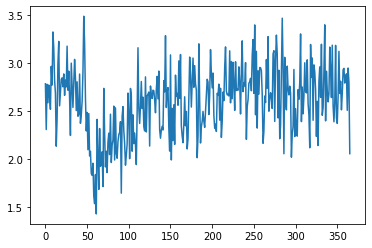

In [7]:
snrlist = []
for i in range(fid.shape[0]):
    snrlist.append(
        pyAMARES.kernel.fid.fidSNR(fid[i, :], indsignal=(0, 10), pts_noise=50)
    )
snrlist = np.array(snrlist)
plt.plot(snrlist)

## Start AMARES fitting

Initialize FID Data and Fitting Parameter Object using `pyAMARES.initialize_FID`

1. **Initialize Fitting Parameters**  
   Begin by setting up the initial fitting parameters.

2. **Preview the Loaded Parameters**  
   Display the parameters in a figure to visually verify and adjust as needed.

3. **Preview the Loaded Prior Knowledge Table**  
   Display the prior knowledge table, which has been converted from the MATLAB file `AMARES.priorKnowledge.PK_31P_3T_muscle_AS_TA_171122_JJM.m`, to ensure it faithfully reproduces the OXSA's prior knowledge dataset.

In [8]:
# Normalize and calculate the mean FID from all FIDs
fid2 = fid / np.max(np.abs(fid))
fidsum = np.mean(fid2, axis=0)

Checking comment lines in the prior knowledge file


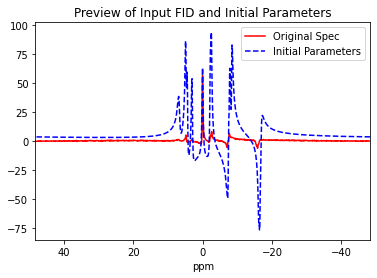

Printing the Prior Knowledge File JJM_3T_v3.csv


,PCr,PME,Pia,Pib,PDE,BATP,BATP2,BATP3,AATP,AATP2,GATP,GATP2,NAD
Index,,,,,,,,,,,,,
Initial Values,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amplitude,1,1,1,1,1,1,BATP/2,BATP/2,1,AATP,1,GATP,1
chemicalshift,0,6.7,4.83,4.38,3.02,-16.54,BATP-15Hz,BATP+15Hz,-7.48,AATP-16Hz,-2.22,GATP-15Hz,-8.4
linewidth,20,40,20,20,20,20,BATP,BATP,20,AATP,20,GATP,20
phase,0,PCr,PCr,PCr,PCr,PCr,PCr,PCr,PCr,PCr,PCr,PCr,PCr
g,0,0,0,0,0,0,0,0,0,0,0,0,0
Bounds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amplitude,"(0,","(0,","(0,","(0,","(0,","(0,","(0,","(0,","(0,","(0,","(0,","(0,","(0,"
chemicalshift,"(-0.5,0.2)","(6.00, 7.10)","(4.19,5.03)","(3.69, 4.39)","(2.87, 3.27)","(-17,-15)","(-17,-15)","(-17,-15)","(-8,-6)","(-8,-6)","(-3,-2)","(-3,-2)","(-8.45, -8.35)"


In [9]:
pkfile = "JJM_3T_v3.csv"
FIDobj = pyAMARES.initialize_FID(
    fidsum,
    priorknowledgefile=pkfile,
    MHz=bofreq,
    sw=sw,
    deadtime=beginTime,
    normalize_fid=False,
    flip_axis=False,
    preview=True,
)

### Initialize Fitting Parameters from the Mean Spectrum

Fitting Strategies
There are two primary fitting methods available:

1. **leastsq: Levenberg-Marquardt Algorithm**
   - **Speed**: Faster
   - **Description**: Levenberg-Marquardt algorithm, can be used to obtain the initial fitting parameters for `least_squares`.

2. **least_squares: Trust Region Reflective Method**
   - **Speed**: Slower
   - **Description**: Trust Region Reflective, the method used in OXSA. Though it is slower, it often yields better fitting results.


A copy of the input fid_parameters will be returned because inplace=False
Autogenerated tol is 7.949e-07
Fitting with method=leastsq took 4.872845 seconds
Estimated CRLBs are calculated using the default noise variance estimation used by OXSA.


/home/jxu125/git/pyamares/pyAMARES/util/crlb.py:54: RuntimeWarning: Warning: The matrix may be ill-conditioned. Condition number is high: 1.441e+14
  warnings.warn(


a_sd is all None, use crlb instead!
freq_sd is all None, use crlb instead!
lw_sd is all None, use crlb instead!
phase_sd is all None, use crlb instead!
g_std is all None, use crlb instead!
Lmfit Fitting Results:
----------------
Number of function evaluations (nfev): 1000
Reduced chi-squared (redchi): 0.00022850571236512654
Fit success status: Failure
Fit message: Tolerance seems to be too small. Could not estimate error-bars.
Norm of residual = 0.462
Norm of the data = 11.827
resNormSq / dataNormSq = 0.039


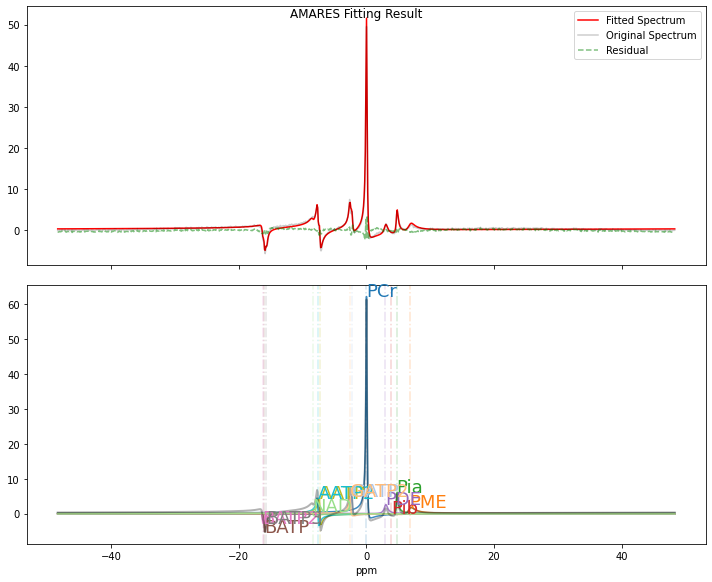

In [10]:
out1 = pyAMARES.fitAMARES(
    fid_parameters=FIDobj,
    fitting_parameters=FIDobj.initialParams,
    method="leastsq",
    ifplot=True,
    inplace=False,
)

Modify the plotting parameters to visualize the AMARES fitting results.

In [11]:
plotParameters = (
    FIDobj.plotParameters
)  # Get the template of plotParameters from an FID object
plotParameters.xlim = (15, -20)  # Set the ppm range from 15 to -20 ppm
plotParameters.ifphase = True  # Enable phasing of the spectrum for better visualization. Note: As AMARES utilizes a time-domain fitting strategy,
# phasing the FID is not required for the fitting process but may be useful for visualization.
plotParameters.lb = 5.0  # linebroadening of 5 Hz
plotParameters

Namespace(deadtime=0.000455, ifphase=True, lb=5.0, sw=5000.0, xlim=(15, -20))

Visualization of the AMARES Fitting Result (Optional)
- This section demonstrates how to plot the fitting results using the `pyAMARES.plotAMARES` function.


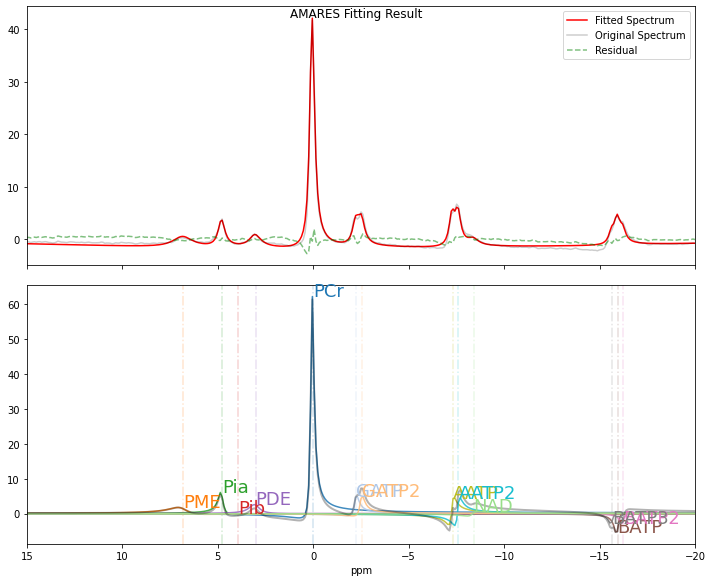

In [12]:
pyAMARES.plotAMARES(
    fid_parameters=out1,  # `out1` is the output from `fitAMARES` containing the fitted parameters.
    fitted_params=out1.fittedParams,  # # Optional: If omitted, `out1.fittedParams` is used by default.
    plotParameters=plotParameters,
)

The fitted parameters of the mean spectrum can be accessed using `out1.fittedParams`.

In [13]:
out1.fittedParams

name,value,initial value,min,max,vary,expression
ak_PCr,0.42801070,1.0,0.00000000,inf,True,
freq_PCr,0.99136334,0.0,-25.8603225,10.3441290,True,
dk_PCr,33.1927771,62.83185307179586,0.00000000,72.2566310,True,
phi_PCr,-0.30070732,0.0,-3.14159265,3.14159265,True,
g_PCr,0.00000000,0.0,0.00000000,1.00000000,False,
ak_PME,0.08179148,1.0,0.00000000,inf,True,
freq_PME,352.457521,346.5283215,310.323870,367.216579,True,
dk_PME,188.495559,125.66370614359172,0.00000000,188.495559,True,
phi_PME,-0.30070732,0.0,-3.14159265,3.14159265,False,phi_PCr
g_PME,0.00000000,0.0,0.00000000,1.00000000,False,


#### Accessing Detailed Fitting Results in the FID object, such as `out1`

1. **Detailed Peak Parameters including Multiplets**
   - **Variable**: `out1.result_multiplet`
   - **Description**: Contains the fitted parameters for each peak, including sub-peaks within multiplets.

2. **Peak Parameters**
   - **Variable**: `out1.result_sum`
   - **Description**: Provides the summation of all multiplets, offering a consolidated view of the spectrum's fitting results.

3. **Enhanced Visualization of Data**
   - **Variable**: `out1.styled_df`
   - **Description**: This data frame is styled to highlight statistical reliability, color-coding entries where the Cramer-Rao Lower Bounds (CRLB) are less than 20%. This visualization aids in identifying the most statistically reliable parameters.


In [14]:
out1.styled_df

,amplitude,sd,CRLB(%),chem shift(ppm),sd(ppm),CRLB(cs%),LW(Hz),sd(Hz),CRLB(LW%),phase(deg),sd(deg),CRLB(phase%),g,g_sd,g (%),SNR
name,,,,,,,,,,,,,,,,
PCr,0.428,0.003,0.622,0.019,0.001,4.676,10.566,0.091,0.864,-17.229,-0.368,2.136,0.000,nan,nan,49.769
PME,0.082,0.007,9.106,6.815,0.044,0.644,60.000,7.111,11.851,-17.229,-0.368,2.136,0.000,nan,nan,9.511
Pia,0.070,0.004,5.146,4.765,0.008,0.164,17.147,1.198,6.984,-17.229,-0.368,2.136,0.000,nan,nan,8.171
Pib,0.000,0.001,81244.631,3.947,18.202,461.156,1.891,3084.591,163100.438,-17.229,-0.368,2.136,0.000,nan,nan,0.000
PDE,0.059,0.005,9.009,3.012,0.026,0.877,34.399,4.172,12.127,-17.229,-0.368,2.136,0.000,nan,nan,6.841
BATP,0.107,0.003,3.269,-15.941,-0.007,0.046,13.650,0.976,7.151,-17.229,-0.368,2.136,0.000,nan,nan,12.423
AATP,0.135,0.004,2.775,-7.297,-0.005,0.063,13.294,0.637,4.795,-17.229,-0.368,2.136,0.000,nan,nan,15.754
GATP,0.115,0.004,3.233,-2.264,-0.007,0.299,15.585,0.969,6.219,-17.229,-0.368,2.136,0.000,nan,nan,13.395
NAD,0.026,0.005,20.577,-8.400,-0.048,0.570,29.303,7.850,26.789,-17.229,-0.368,2.136,0.000,nan,nan,3.045


DC correction

In [15]:
quarter_length = round(FIDobj.timeaxis.shape[0] * 0.25)  # 1/4, 256 points
fid3 = np.zeros(fid2.shape, dtype=fid2.dtype)
dc_offset_arr = np.mean(fid2[:, -quarter_length - 1 :], axis=1)
fid3 = fid2 - dc_offset_arr[:, np.newaxis]
print("DC correction by the mean of the last %i points" % quarter_length)

DC correction by the mean of the last 256 points


Futher Optimization of Initial Parameters for batch fitting (Optional)

A copy of the input fid_parameters will be returned because inplace=False
Autogenerated tol is 9.188e-07
Fitting with method=least_squares took 3.171307 seconds
Estimated CRLBs are calculated using the default noise variance estimation used by OXSA.
Lmfit Fitting Results:
----------------
Number of function evaluations (nfev): 15
Reduced chi-squared (redchi): 0.01191279256392595
Fit success status: Success
Fit message: `ftol` termination condition is satisfied.
Norm of residual = 24.064
Norm of the data = 38.047
resNormSq / dataNormSq = 0.632


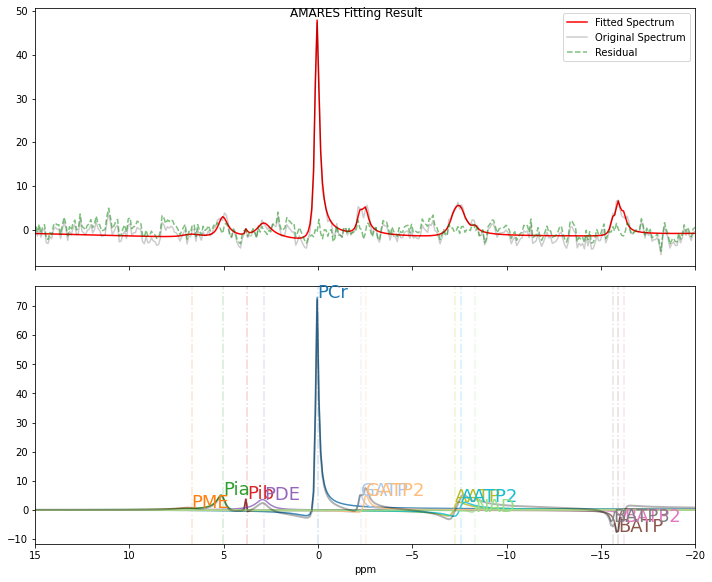

In [16]:
FIDobj.fid = fid3[
    1, :
]  # Update the FID in the FIDobj to the first spectrum of DC-corrected FIDs.
out2 = pyAMARES.fitAMARES(
    fid_parameters=FIDobj,
    fitting_parameters=out1.fittedParams,  # You can use either FIDobj.initialParameters, which are directly loaded from the prior knowledge,
    # or the fitted parameters from a previous round of AMARES fitting, such as out1.fittedParams.
    method="least_squares",
    ifplot=True,
    inplace=False,
)

Fitted Results from the First FID:
- The results obtained from fitting a single FID are  less reliable than those derived from the mean spectrum.


In [17]:
out2.styled_df

,amplitude,sd,CRLB(%),chem shift(ppm),sd(ppm),CRLB(cs%),LW(Hz),sd(Hz),CRLB(LW%),phase(deg),sd(deg),CRLB(phase%),g,g_sd,g (%),SNR
name,,,,,,,,,,,,,,,,
PCr,0.452,0.017,3.717,0.026,0.005,18.350,9.374,0.499,5.178,-19.355,2.269,11.413,0.000,0.000,nan,2.683
PME,0.031,0.057,180.420,6.697,0.837,12.167,60.000,141.056,228.880,-19.355,2.269,11.413,0.000,0.000,nan,0.181
Pia,0.094,0.036,36.839,5.030,0.079,1.530,26.746,12.936,47.089,-19.355,2.269,11.413,0.000,0.000,nan,0.560
Pib,0.006,0.009,149.109,3.762,0.027,0.706,1.167,4.995,416.694,-19.355,2.269,11.413,0.000,0.000,nan,0.033
PDE,0.107,0.044,40.011,2.870,0.149,5.038,44.319,24.075,52.886,-19.355,2.269,11.413,0.000,0.000,nan,0.633
BATP,0.130,0.022,16.157,-15.933,0.029,0.179,11.094,3.659,32.110,-19.355,2.269,11.413,0.000,0.000,nan,0.771
AATP,0.184,0.042,22.216,-7.262,0.066,0.887,28.950,11.450,38.504,-19.355,2.269,11.413,0.000,0.000,nan,1.090
GATP,0.110,0.024,21.246,-2.254,0.042,1.835,14.252,5.920,40.442,-19.355,2.269,11.413,0.000,0.000,nan,0.655
NAD,0.011,0.023,205.125,-8.350,0.197,2.291,11.838,31.881,262.197,-19.355,2.269,11.413,0.000,0.000,nan,0.066


### Batch Fitting: Loop to get all amplitude results
- `run_parallel_fitting_with_progress` is designed to batch fit multiple FIDs simultaneously, utilizing a specified number of CPUs to enhance speed performance.

- It typically takes 7~10 min to fit 366 FIDs using the 2 CPUs available of Google Colab.

In [18]:
fid3.shape

(366, 1024)

In [19]:
result_list = pyAMARES.run_parallel_fitting_with_progress(
    fid3,  # 2D array of FIDs. Here, `fid3.shape=(366,1024)` indicates 366 FIDs, each with 1024 points.
    FIDobj_shared=out2,  # Use the FID object `out2` for fitting all FIDs.
    initial_params=out2.fittedParams,  # Use the fitted results of the first FID as the initial parameters.
    num_workers=30,  # Parallel processing with 2 sessions if used in Google Colab, suitable for the 2 CPUs available in Google Colab.
    initialize_with_lm=True,
    method="leastsq",
)  # Use the Levenberg-Marquardt method by default for faster processing.

Processing Datasets:   0%|          | 0/366 [00:00<?, ?it/s]

Fitting 366 spectra with 30 processors took 101 seconds


Smoothing data

In [20]:
amplist = []
for out_table in result_list:
    amplist.append(out_table["amplitude"].values)
fid_amp = np.array(amplist)
fid_amp.shape

(366, 13)

Define a smooth function to mimic `smooth` in Matlab

In [21]:
def smooth(x, window_len=11, window="hanning", verbose=False):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len < 3:
        return x

    if window not in ["flat", "hanning", "hamming", "bartlett", "blackman"]:
        raise ValueError(
            "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        )

    s = np.r_[x[window_len - 1 : 0 : -1], x, x[-2 : -window_len - 1 : -1]]
    if window == "flat":  # moving average
        w = np.ones(window_len, "d")
    else:
        w = eval("np." + window + "(window_len)")

    y = np.convolve(w / w.sum(), s, mode="valid")
    if verbose:
        print("input len", len(x))
        print("output len", len(y))
    y2 = y[(window_len // 2) : -(window_len // 2)]
    if verbose:
        print("output len", len(y2))
    return y2

Determine PCr rise time

In [22]:
fid_amp.shape[0]
kinec_smooth = 11
fid_amp_smooth = np.zeros_like(
    fid_amp
)  # Initialize fid_amp_smooth with the same shape and type as fid_amp
for i in range(fid_amp.shape[1]):
    fid_amp_smooth[:, i] = smooth(fid_amp[:, i], kinec_smooth, verbose=False)

In [23]:
recovery_start_time = np.argmin(fid_amp_smooth[:, 0])
recovery_end_time = fid_amp_smooth.shape[0]  # or simply len(fid_amp_smooth)

PCr_recovery_raw = fid_amp[recovery_start_time:recovery_end_time, 0]  # Raw PCr data
PCr_recovery_avg = fid_amp_smooth[
    recovery_start_time:recovery_end_time, 0
]  # Smoothed PCr data

In [24]:
from scipy.optimize import curve_fit


t_rec = TR * (np.arange(len(PCr_recovery_avg)) + 1)


# Define the mono-exponential function to fit
def mono_exp(x, a, b, c):
    return a - b * np.exp(-x / c)


# Initial guess for the parameters
initial_guess = [
    np.max(PCr_recovery_avg),
    np.max(PCr_recovery_avg) - np.min(PCr_recovery_avg),
    1,
]

# Perform the fit
params, cov = curve_fit(mono_exp, t_rec, PCr_recovery_avg, p0=initial_guess)

# Use the fitted parameters to generate the fitted curve
xx = np.linspace(1, TR * len(PCr_recovery_avg), len(PCr_recovery_avg))
fitted_curve = mono_exp(xx, *params)

In [25]:
# Use the fitted parameters to calculate the predicted values
predicted = mono_exp(t_rec, *params)

# Calculate the total sum of squares (SST)
sst = np.sum((PCr_recovery_avg - np.mean(PCr_recovery_avg)) ** 2)

# Calculate the residual sum of squares (SSR)
ssr = np.sum((PCr_recovery_avg - predicted) ** 2)

# Calculate R^2
r_squared = 1 - (ssr / sst)

print("R^2:", r_squared)

R^2: 0.913155558241575


Plot data

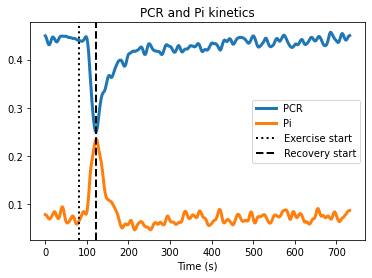

In [26]:
plt.figure()
plt.plot(time_axis, fid_amp_smooth[:, 0], linewidth=3, label="PCR")
plt.plot(
    time_axis, fid_amp_smooth[:, 2] + fid_amp_smooth[:, 3], linewidth=3, label="Pi"
)
plt.title("PCR and Pi kinetics")
plt.xlabel("Time (s)")
plt.legend(loc=3)

# Adding vertical lines for exercise start and recovery start
plt.axvline(x=80, linestyle=":", color="k", linewidth=2, label="Exercise start")
plt.axvline(
    x=time_axis[recovery_start_time],
    linestyle="--",
    color="k",
    linewidth=2,
    label="Recovery start",
)

plt.legend()
plt.show()

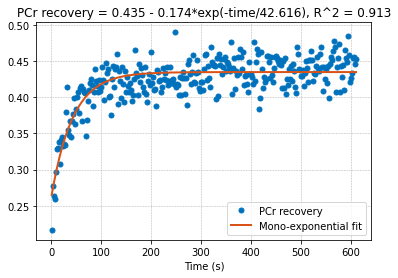

In [27]:
plt.figure()
plt.plot(
    xx,
    PCr_recovery_raw,
    ".",
    color=[0, 0.4470, 0.7410],
    markersize=10,
    label="PCr recovery",
)
plt.plot(
    xx,
    fitted_curve,
    "-",
    color=[0.8500, 0.3250, 0.0980],
    linewidth=2,
    label="Mono-exponential fit",
)

# Assuming f0_avg has attributes 'a', 'b', 'c' for the fit parameters and gof_avg has an attribute 'rsquare' for R^2
plt.title(
    f"PCr recovery = {round(params[0], 3)} - {round(params[1], 3)}*exp(-time/{round(params[2], 3)}), R^2 = {round(r_squared, 3)}"
)
plt.xlabel("Time (s)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(loc=4)
plt.show()